In [54]:
import pandas as pd
import zipfile
import io
import matplotlib.pyplot as plt

# 1) FONCTIONS DE CHARGEMENT

def read_french_zip(path):
    """Lit le contenu texte du CSV contenu dans un ZIP Ken French."""
    z = zipfile.ZipFile(path)
    csv_name = [f for f in z.namelist() if f.lower().endswith(".csv")][0]
    return z.read(csv_name).decode("latin1")

def parse_french_monthly(txt):
    """Parse le CSV Ken French en conservant l'en-tête et la section mensuelle."""
    lignes = txt.splitlines()

    # Trouver début mensuel (yyyyMM)
    debut = None
    for i, ligne in enumerate(lignes):
        premier = ligne.split(",")[0].strip()
        if premier.isdigit() and len(premier) == 6:
            debut = i
            break

    # Trouver l'en-tête juste avant
    entete = None
    for j in range(debut - 1, -1, -1):
        if "," in lignes[j]:
            entete = j
            break

    # Trouver la fin (avant Annual)
    fin = None
    for k in range(debut + 1, len(lignes)):
        if lignes[k].strip() == "" or "Annual" in lignes[k]:
            fin = k
            break
    if fin is None:
        fin = len(lignes)

    # Extraction
    bloc = "\n".join(lignes[entete:fin])
    df = pd.read_csv(io.StringIO(bloc))

    # Conversion date
    date_col = df.columns[0]
    df["date"] = pd.to_datetime(df[date_col].astype(str), format="%Y%m", errors="coerce")
    df = df.dropna(subset=["date"]).set_index("date")
    df = df.drop(columns=[date_col])

    # Conversion numérique
    df = df.apply(pd.to_numeric, errors="coerce")

    return df


# CHARGER LES TROIS FICHIERS

ff5_txt   = read_french_zip("data/F-F_Research_Data_5_Factors_2x3_CSV.zip")
mom_txt   = read_french_zip("data/F-F_Momentum_Factor_CSV.zip")
ind_txt   = read_french_zip("data/17_Industry_Portfolios_CSV.zip")

ff5   = parse_french_monthly(ff5_txt)      # Mkt-RF, SMB, HML, RMW, CMA, RF
mom   = parse_french_monthly(mom_txt)      # momentum UMD
ind17 = parse_french_monthly(ind_txt)      # 17 industries

mom.columns = ["UMD"]                      # renommer proprement la colonne


# FILTRER 1980–2021 & ALIGNER EXACTEMENT

start = "1980-01-01"
end   = "2021-12-31"

ff5 = ff5.loc[start:end]
mom = mom.loc[start:end]
ind17 = ind17.loc[start:end]

idx = ff5.index.intersection(mom.index).intersection(ind17.index)
ff5, mom, ind17 = ff5.loc[idx], mom.loc[idx], ind17.loc[idx]


# CONSTRUIRE LE DATAFRAME FINAL (6 facteurs + 17 industries)

factors = pd.concat([ff5[["Mkt-RF","SMB","HML","RMW","CMA","RF"]], mom], axis=1)
full_df = pd.concat([factors, ind17], axis=1)



In [55]:
# Statistiques pour les 7 facteurs
stats_factors = full_df[["Mkt-RF","SMB","HML","RMW","CMA","UMD"]].describe()
print("\n=== Statistiques descriptive des facteurs ===")
print(stats_factors)

# Statistiques pour les 17 industries
industrie_cols = ['Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum',
                  'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans',
                  'Utils', 'Rtail', 'Finan', 'Other']

stats_industries = full_df[industrie_cols].describe()
print("\n=== Statistiques descriptives des 17 industries ===")
print(stats_industries)



=== Statistiques descriptive des facteurs ===
           Mkt-RF         SMB         HML         RMW         CMA         UMD
count  504.000000  504.000000  504.000000  504.000000  504.000000  504.000000
mean     0.743333    0.095198    0.203155    0.374187    0.251905    0.524266
std      4.476091    2.896355    3.028519    2.403614    1.972099    4.478624
min    -23.190000  -15.540000  -13.830000  -18.950000   -6.410000  -34.340000
25%     -1.912500   -1.587500   -1.505000   -0.755000   -1.020000   -1.192500
50%      1.180000    0.005000    0.055000    0.315000    0.080000    0.605000
75%      3.482500    1.872500    1.755000    1.372500    1.475000    2.840000
max     13.580000   18.460000   12.240000   13.050000    9.010000   18.020000

=== Statistiques descriptives des 17 industries ===
             Food       Mines         Oil       Clths       Durbl       Chems  \
count  504.000000  504.000000  504.000000  504.000000  504.000000  504.000000   
mean     1.210000    0.951806    0.9

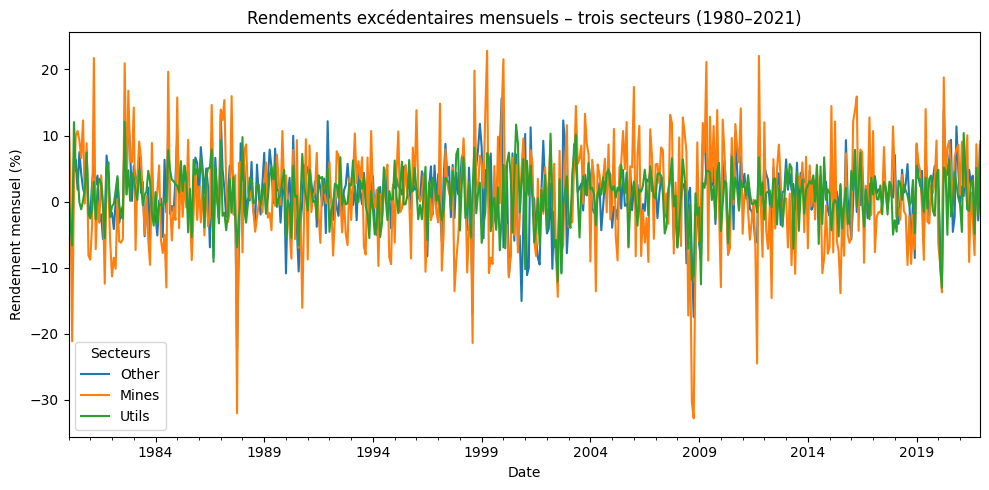

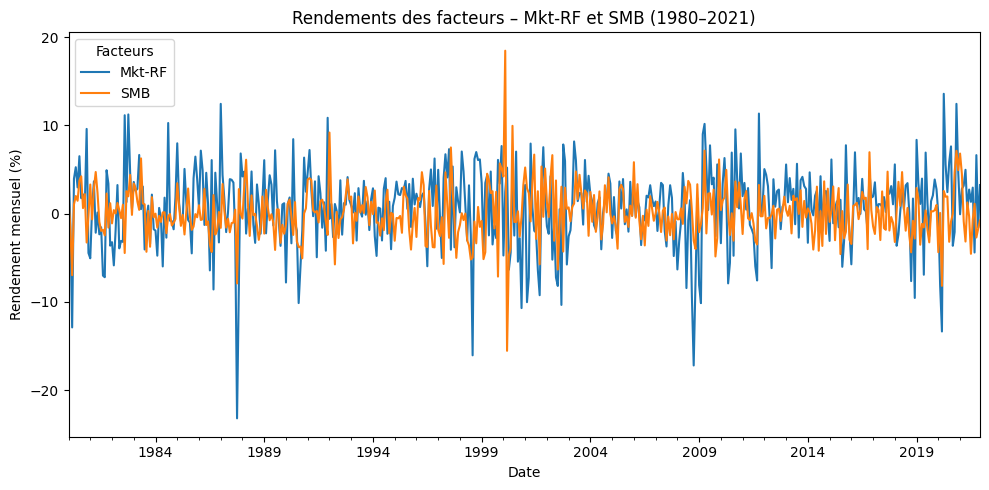

In [56]:
# Graphique pour 3 secteurs 

secteurs = ["Other", "Mines", "Utils"]   

plt.figure(figsize=(10, 5))
full_df[secteurs].plot(ax=plt.gca())
plt.title("Rendements excédentaires mensuels – trois secteurs (1980–2021)")
plt.xlabel("Date")
plt.ylabel("Rendement mensuel (%)")
plt.legend(title="Secteurs")
plt.tight_layout()
plt.show()


# Graphique pour 2 facteurs

facteurs = ["Mkt-RF", "SMB"]              

plt.figure(figsize=(10, 5))
full_df[facteurs].plot(ax=plt.gca())
plt.title("Rendements des facteurs – Mkt-RF et SMB (1980–2021)")
plt.xlabel("Date")
plt.ylabel("Rendement mensuel (%)")
plt.legend(title="Facteurs")
plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np


# 1) Définition des secteurs et facteurs


factors_list = ["Mkt-RF","SMB","HML","RMW","CMA","UMD"]

sector_list = ['Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum',
               'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans',
               'Utils', 'Rtail', 'Finan', 'Other']

# dataframe des facteurs
F = full_df[factors_list]

# dataframe des rendements excédentaires sectoriels
R = full_df[sector_list]



# Estimation OLS secteur par secteur


results = {}
betas = pd.DataFrame(index=sector_list, columns=factors_list)
alphas = pd.Series(index=sector_list, dtype=float)
tstats = pd.DataFrame(index=sector_list, columns=["alpha"] + factors_list)
r2 = pd.Series(index=sector_list, dtype=float)

for sector in sector_list:
    
    y = R[sector]                   # Série: rendements du secteur i
    X = sm.add_constant(F)          # Constante + six facteurs
    
    ols_model = sm.OLS(y, X)        # Création du modèle OLS
    model = ols_model.fit()         
    
    # Extraction des coefficients
    alphas[sector] = model.params["const"]
    betas.loc[sector, :] = model.params[factors_list]
    
    # t-stat OLS
    tstats.loc[sector, "alpha"] = model.tvalues["const"]
    for f in factors_list:
        tstats.loc[sector, f] = model.tvalues[f]
    
    # R²
    r2[sector] = model.rsquared
    
    # sauve le modèle complet
    results[sector] = model



# R² moyen, bêtas moyens et présentation


print("\n=== R² par secteur ===")
print(r2)

print("\n=== Bêtas ===")
print(betas)

print("\n=== Tableau complet des t-stat robustes ===")
print(tstats)




=== R² par secteur ===
Food     0.587738
Mines    0.360759
Oil      0.461667
Clths    0.696989
Durbl    0.764539
Chems    0.736743
Cnsum    0.608148
Cnstr    0.765275
Steel    0.657172
FabPr    0.766511
Machn    0.818979
Cars     0.604963
Trans    0.771206
Utils    0.375173
Rtail    0.680390
Finan    0.860593
Other    0.936284
dtype: float64

=== Bêtas ===
         Mkt-RF       SMB       HML       RMW       CMA       UMD
Food   0.784829 -0.108678 -0.088228  0.541364  0.456205  0.024246
Mines  1.039134   0.41956 -0.000413  0.024589  0.523049  0.003175
Oil    1.012155  0.115972  0.420475  0.235331  0.227619  0.028551
Clths  1.048346  0.476069  0.110005  0.695242 -0.052075 -0.211526
Durbl  1.079464  0.379014  0.046748   0.35318  0.293669 -0.178468
Chems  1.140116  0.117794  0.209613  0.353884  0.189492 -0.120591
Cnsum  0.808825 -0.302256 -0.302496  0.370631  0.543622  0.002463
Cnstr  1.199092  0.259556  0.159287  0.350322  0.080824  0.022355
Steel  1.330594  0.479951  0.225246 -0.222814 

In [ ]:
from scipy.stats import chi2

# Rendements moyens

mean_returns = R.mean()      


# Préparer X (bêtas) et y


# forcer en float et aligner les index
betas_float = betas.astype(float)
mean_float  = mean_returns.astype(float)

# s'assurer qu'on a les mêmes secteurs dans les deux
common_sectors = betas_float.index.intersection(mean_float.index)
betas_float = betas_float.loc[common_sectors]
mean_float  = mean_float.loc[common_sectors]

# supprimer lignes avec NaN
mask_valid = (~betas_float.isna().any(axis=1)) & (~mean_float.isna())
betas_float = betas_float[mask_valid]
mean_float  = mean_float[mask_valid]

# matrice X et vecteur y
X = betas_float.to_numpy()          # (N x 6)
y = mean_float.to_numpy()           # (N,)

# ajouter constante
X = sm.add_constant(X)


# 3) Régression OLS

lambda_model = sm.OLS(y, X).fit(cov_type="HC3")  # t robustes de White

lambda_hat   = lambda_model.params
tstats_lambda = lambda_model.tvalues

param_names = ["alpha"] + factors_list  # factors_list = ["Mkt-RF","SMB","HML","RMW","CMA","UMD"]

print("=== Prix du risque λ estimés ===")
print(pd.Series(lambda_hat, index=param_names))

print("\n=== t-stat robustes (HC3) ===")
print(pd.Series(tstats_lambda, index=param_names))


# 4) Test J (simple)

residuals = y - X @ lambda_hat      # η_i = R̄_i − λ'β_i

J_stat = residuals.T @ residuals    # W = I
df = len(mean_float) - len(lambda_hat)   # N - (k+1)

p_value = 1 - chi2.cdf(J_stat, df)

print("\n=== Test J d'évaluation du modèle ===")
print("J =", J_stat)
print("df =", df)
print("p-value =", p_value)


=== Prix du risque λ estimés ===
alpha     0.603578
Mkt-RF    0.540615
SMB      -0.432939
HML      -0.296370
RMW       0.341918
CMA      -0.215166
UMD       0.179185
dtype: float64

=== t-stat robustes (HC3) ===
alpha     1.834285
Mkt-RF    1.646477
SMB      -1.657020
HML      -2.468537
RMW       3.114024
CMA      -1.091397
UMD       0.270686
dtype: float64

=== Test J d'évaluation du modèle ===
J = 0.0782928789103786
df = 10
p-value = 0.9999999992584864


In [61]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
from scipy.stats import chi2

# Reprendre les bêtas et rendements moyens utilisés avant
betas_float = betas.astype(float)
mean_float  = R.mean().astype(float)

common_sectors = betas_float.index.intersection(mean_float.index)
betas_float = betas_float.loc[common_sectors]
mean_float  = mean_float.loc[common_sectors]

mask_valid = (~betas_float.isna().any(axis=1)) & (~mean_float.isna())
betas_float = betas_float[mask_valid]
mean_float  = mean_float[mask_valid]

# X sans constante 
X_nc = betas_float.to_numpy()      #
y_nc = mean_float.to_numpy()       

# Régression sans intercepte
lambda_model_nc = sm.OLS(y_nc, X_nc).fit(cov_type="HC3")

lambda_hat_nc   = lambda_model_nc.params
tstats_nc       = lambda_model_nc.tvalues

print("=== λ (FACTEURS NON NEGOCIES) ===")
print(pd.Series(lambda_hat_nc, index=factors_list))

print("\n=== t-stats robustes (HC3) ===")
print(pd.Series(tstats_nc, index=factors_list))

# Test J 
residuals_nc = y_nc - X_nc @ lambda_hat_nc
J_nc = residuals_nc.T @ residuals_nc

df_nc = len(mean_float) - len(lambda_hat_nc)   # N - k
p_nc = 1 - chi2.cdf(J_nc, df_nc)

print("\n=== Test J (sans constante) ===")
print("J =", J_nc)
print("df =", df_nc)
print("p-value =", p_nc)


=== λ (FACTEURS NON NEGOCIES) ===
Mkt-RF    1.149790
SMB      -0.618290
HML      -0.369382
RMW       0.454151
CMA      -0.169154
UMD       0.591120
dtype: float64

=== t-stats robustes (HC3) ===
Mkt-RF    21.791714
SMB       -2.576043
HML       -2.640569
RMW        3.370248
CMA       -0.937243
UMD        1.058666
dtype: float64

=== Test J (sans constante) ===
J = 0.13569228209130305
df = 11
p-value = 0.9999999987718421
